[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sensioai/blog/blob/master/049_cv_ssd/cv_ssd.ipynb)

# Implementando SSD

En este post vamos a implementar una `red neuronal convolucional` para detección de objetos desde cero. Para ello nos inspiramos en el modelo `SSD`, una arquitectura muy utilizada por su versatilidad y eficiencia.

In [575]:
import torch
import torchvision

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

Vamos a utilizar el mismo dataset que conocemos de posts anteriores, el dataset `VOC`.

In [445]:
train = torchvision.datasets.VOCDetection('./data', download=True)
len(train)

Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar


5717

In [446]:
classes = ["background","aeroplane","bicycle","bird","boat",
"bottle","bus","car","cat","chair","cow","diningtable","dog",
"horse","motorbike","person","pottedplant","sheep","sofa",
"train","tvmonitor"]

Las siguientes funciones nos ayudan a extraer la información que necesitamos de las anotaciones y a visualizar muestras del dataset.

In [473]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.patheffects as PathEffects
import random

def get_sample(ix):
  img, label = train[ix]
  img_np = np.array(img)
  anns = label['annotation']['object']
  if type(anns) is not list:
    anns = [anns]
  labels = np.array([classes.index(ann['name']) for ann in anns])
  bbs = [ann['bndbox'] for ann in anns]
  bbs = np.array([[int(bb['xmin']), int(bb['ymin']),int(bb['xmax']),int(bb['ymax'])] for bb in bbs])
  anns = (labels, bbs)
  return img_np, anns

def plot_anns(img, anns, ax=None, bg=-1):
  # anns is a tuple with (labels, bbs)
  # bbs is an array of bounding boxes in format [x_min, y_min, x_max, y_max] 
  # labels is an array containing the label 
  if not ax:
    fig, ax = plt.subplots(figsize=(10, 6))
  ax.imshow(img)
  labels, bbs = anns
  for lab, bb in zip(labels, bbs):
    if bg == -1 or lab != bg:
      x, y, xm, ym = bb
      w, h = xm - x, ym - y
      rect = mpatches.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=2)
      text = ax.text(x, y - 10, classes[lab], {'color': 'red'})
      text.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
      ax.add_patch(rect)

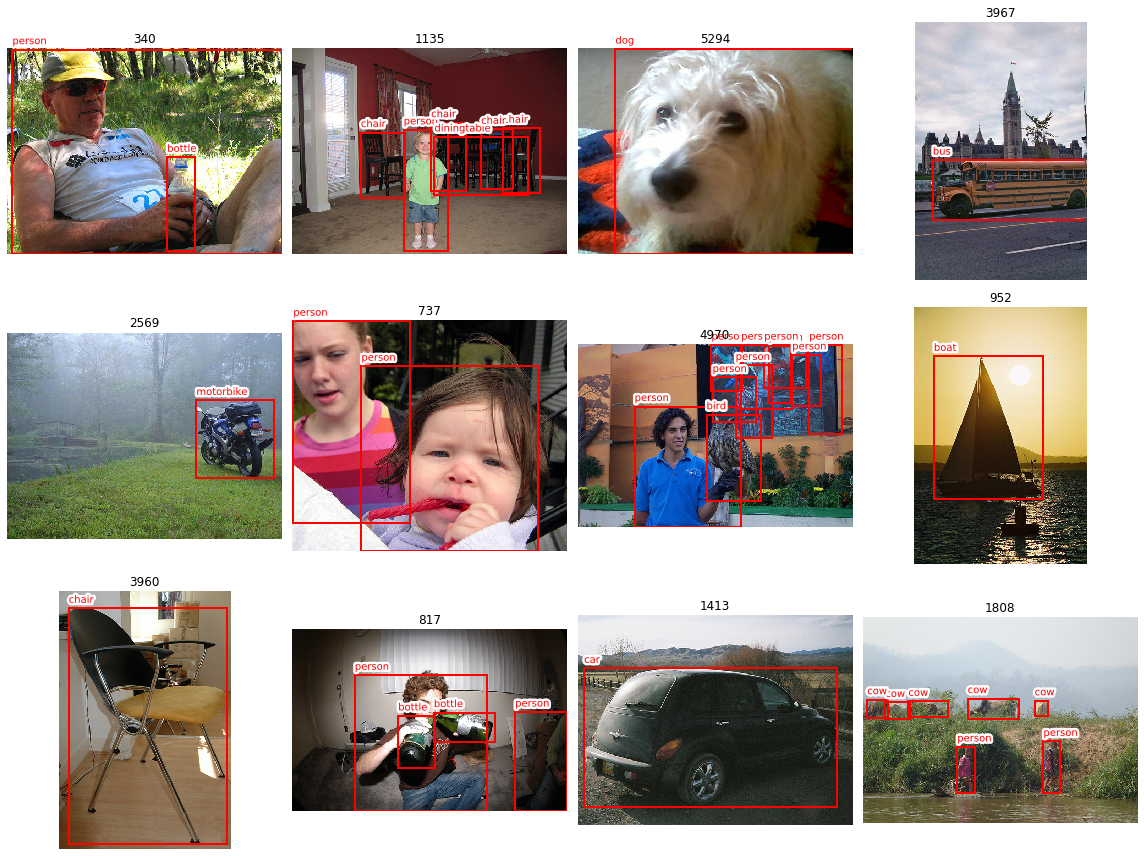

In [548]:
r, c = 3, 4
fig = plt.figure(figsize=(4*c, 4*r))
for _r in range(r):
    for _c in range(c):
        ax = plt.subplot(r, c, _r*c + _c + 1)
        ix = random.randint(0, len(train)-1)
        ax.set_title(ix)
        img_np, anns = get_sample(ix)
        plot_anns(img_np, anns, ax)
        plt.axis("off")
plt.tight_layout()
plt.show()

Como puedes ver, en el dataset hay imágenes con una detección, otras con más de una. Algunas detecciones ocupan gran parte de la imagen, otras son pequeñas. En algunas imágenes incluso podemos tener múltiples detecciones de la misma clase... ¿Cómo podemos definir un modelo que sea capaz de darnos un número indeterminado de detecciones? En el caso del modelo `SSD`, y en general todos los detectores de una etapa, nosotros definimos un conjunto de cajas definido que la red utilizará durante el entrenamiento para generar detecciones.

## Propuesta de cajas

In [475]:
def norm(bb, shape):
  # normalize bb
  # shape = (heigh, width)
  # bb = [x_min, y_min, x_max, y_max]
  h, w = shape
  return np.array([bb[0]/w, bb[1]/h, bb[2]/w, bb[3]/h])

def unnorm(bb, shape):
  # unnormalize bb
  # shape = (heigh, width)
  # bb = [x_min, y_min, x_max, y_max]
  h, w = shape
  return np.array([bb[0]*w, bb[1]*h, bb[2]*w, bb[3]*h])

def xyxy2xywh(bb):
  return torch.stack([bb[:,0], bb[:,1], bb[:,2]-bb[:,0], bb[:,3]-bb[:,1]], axis=1)

#def xywh2xyxy(bb):
#  return torch.stack([bb[:,0], bb[:,1], bb[:,0]+bb[:,2], bb[:,1]+bb[:,3]], axis=1)

def generate_anchors(scales, centers, sizes):
    k, anchors, grid_size = [], [], []
    for s in scales:
        cnt = 0
        for (x, y) in centers:
            for (w, h) in sizes:
                for i in range(s):
                    for j in range(s):
                        # cwh
                        #anchors.append(np.array([x+i, y+j, w, h])/s)
                        # xyxy
                        anchors.append(np.array([x+i-w/2, y+j-h/2, x+i+w/2, y+j+h/2])/s)
                        grid_size.append(np.array([1./s,1./s]))
                cnt = cnt + 1
        k.append(cnt)
    return k, torch.tensor(anchors).float(), torch.tensor(grid_size).float()

A la función `generate_anchors` le damos una lista de diferentes escalas a las cuales queremos tener detecciones, otra con el centro de las cajas, la escala y el *aspect ratio*. La función nos devuelve una lista con todas las cajas que el modelo tendrá en cuenta durante el entrenamiento para detectar objetos en ellas.

In [138]:
def plot_anchors(img, anns, anchors, ax=None, overlap=False):
  # anns is a tuple with (bbs, labels)
  # bbs is an array of bounding boxes in format [x_min, y_min, x_max, y_max] 
  # labels is an array containing the label 
  if not ax:
    fig, ax = plt.subplots(figsize=(10, 6))
  ax.imshow(img)
  labels, bbs = anns

  anchors = xyxy2xywh(anchors)
  _anchors = np.array([unnorm(a, img.shape[:2]) for a in anchors])
  for a in _anchors:
    x, y, w, h = a
    rect = mpatches.Rectangle((x, y), w, h, fill=False, edgecolor='green', linewidth=2)
    ax.add_patch(rect)

  labels, bbs = anns
  for lab, bb in zip(labels, bbs):
    x, y, xm, ym = bb
    w, h = xm - x, ym - y
    rect = mpatches.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=2)
    text = ax.text(x, y - 10, classes[lab], {'color': 'red'})
    text.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
    ax.add_patch(rect)

(138, [3, 3, 3])

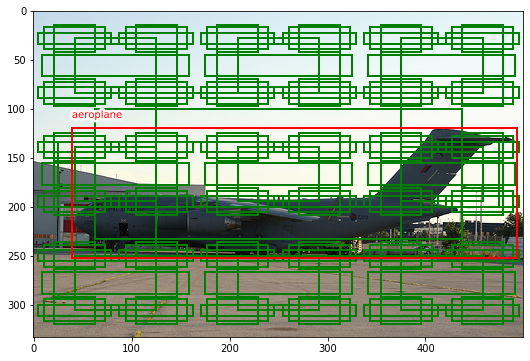

In [549]:
ix = 4445
img_np, anns = get_sample(ix)
labels, bbs = anns

scales = [6, 3, 1]               
centers = [(0.5, 0.5)] 
size_scales = [0.5]
aspect_ratios = [(1., 1.), (1.5, 0.8), (1.8, 0.4)]
sizes = [(s*a[0], s*a[1]) for s in size_scales for a in aspect_ratios]
k, anchors, grid_size = generate_anchors(scales, centers, sizes)

plot_anchors(img_np, anns, anchors)
len(anchors), k

La eficiencia y precisión del modelo dependerá del número de cajas que propongamos así como su número. Muchas cajas nos darán un modelo lento, pero potencialmente más preciso. Por otro lado, si en nuestra aplicación conocemos bien la escala y tamaño al que se encuentran los objetos que queremos detectar, poner sólo cajas en esas escalas dará como resultado un modelo preciso y eficiente (aquí estaremos introduciendo conocimiento experto, o *priors*, a nuestro modelo perdiendo flexibilidad).

Como puedes estar pensando, de querer ser capaces de detectar objetos de manera precisa simplemente con las cajas propuestas, deberíamos tener muchísimas de estas cajas (potencialmente cubriendo todo el espacio). Es por esto que nuestro modelo no sólo clasificará objetos dentro de las cajas propuestas sino que además también predecirá unos *offsets*, modificaciones sobre las cajas propuestas, para acabar de ajustar la detección (básicamente, un *offset* en el centro de la caja, su ancho y alto).

## El Modelo

Inspirándonos en la implementación del modelo `SSD` original, necesitamos una `backbone` que extraiga características de la imagen y luego varias `heads` que produzcan las clasificaciones y los *offests* sobre las cajas propuestas. Estas `heads` son alimentadas con las salidas de diferentes capas convolucionales de la `backbone`, permitiendo así la detección a múltiples escalas. Estas escalas deben coincidir con las definidas a la hora de generar nuestras propuestas de cajas (si no las dimensiones no encajarán).

![](https://miro.medium.com/max/1100/1*up-gIJ9rPkHXUGRoqWuULQ.jpeg)

In [550]:
def block(c_in, c_out, k=3, p=1, s=1, pk=2, ps=2):
    return torch.nn.Sequential(
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s),
        torch.nn.ReLU(),
        #torch.nn.BatchNorm2d(c_out),
        torch.nn.MaxPool2d(pk, stride=ps)
    )

def flatten_conv(x, k):
    return x.view(x.size(0), x.size(1)//k, -1).transpose(1,2)

class out_conv(torch.nn.Module):
    def __init__(self, c_in, k, n_classes):
        super().__init__()
        self.k = k
        self.oconv1 = torch.nn.Conv2d(c_in, k*4, 3, padding=1)
        self.oconv2 = torch.nn.Conv2d(c_in, k*n_classes, 3, padding=1)
    def forward(self, x):
        return [
            flatten_conv(self.oconv1(x), self.k),
            flatten_conv(self.oconv2(x), self.k)
        ]

def conv(c_i, c_o, stride=2, padding=1):
    return nn.Sequential(
        nn.Conv2d(c_i, c_o, 3, stride=stride, padding=padding), 
        nn.ReLU(),
        #nn.BatchNorm2d(c_o)
    )

class SSD(torch.nn.Module):
  def __init__(self, n_channels=3, n_classes=20, k=[1, 1, 1]):
    super().__init__()
    # backbone
    self.conv1 = block(n_channels, 8)
    self.conv2 = block(8, 16)
    self.conv3 = block(16, 32)
    self.conv4 = block(32, 64)
    self.conv5 = block(64, 64)
    self.conv6 = block(64, 64)
    # head
    self.k = k
    self.out4 = out_conv(64, self.k[0], n_classes)
    self.out5 = out_conv(64, self.k[1], n_classes)
    self.out6 = out_conv(64, self.k[2], n_classes)

  def forward(self, x):
    # backbone
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)     # para inputs de 100x100
    x4 = self.conv4(x)    # 6x6
    x5 = self.conv5(x4)   # 3x3
    x6 = self.conv6(x5)   # 1x1

    # head
    o1l, o1c = self.out4(x4)
    o2l, o2c = self.out5(x5)
    o3l, o3c = self.out6(x6)
    return torch.cat([o1l,o2l,o3l],dim=1), torch.cat([o1c,o2c,o3c],dim=1)    
    #return o2l, o2c

In [551]:
net = SSD(n_classes=len(classes), k=k)
output = net(torch.rand((64,3,100,100)))
output[0].shape, output[1].shape

(torch.Size([64, 138, 4]), torch.Size([64, 138, 21]))

## La función de pérdida

Durante el entrenamiento, el modelo nos dará 4 valores para cada una de las cajas propuestas (*offests*) así como las 21 probabilidades asignadas a cada clase. De alguna manera, la función de pérdida tiene que comparar estos valores con las cajas reales. En primer lugar tenemos que coger las salidas del modelo y calcular los *offsets*. Para ello, usaremos la función `tanh`, que limita los salidas a valores en el rango (-1, 1), permitiendo un *offset* de hasta el 50% del tamaños de la caja en ambas dimensiones.

In [552]:
def actn_to_bb(actn, anchors, grid_size):
    actn_bbs = torch.tanh(actn)
    actn_p1 = anchors[:,:2] + actn_bbs[:,:2]*grid_size*0.5
    actn_p2 = anchors[:,2:] + actn_bbs[:,2:]*grid_size*0.5
    return torch.cat([actn_p1, actn_p2], dim=1)

El siguiente problema es que cada imagen tiene un número indeterminado de detecciones, por lo que primero tenemos que emparejar las cajas propuestas con aquellas anotaciones con las que mejor coincidan. Para ello usamos una métrica conocida como `IoU`(*intersection over unions*).

![](https://pyimagesearch.com/wp-content/uploads/2016/09/iou_equation.png)

Una vez calculado este valor para cada caja propuesta con respecto a todas las cajas en las etiquetas, nos quedamos con aquellas que superen un `threshold` determinado (por defecto 0.4). Es posible pues tener varias detecciones para un mismo objeto, algo que resolveremos más adelante. También puede ocurrir que no haya ninguna caja que cumpla estos requisitos, es este caso le asignaremos aquella con mayor `IoU`.

In [553]:
def map_to_ground_truth(overlaps):
    prior_overlap, prior_idx = overlaps.max(1)
    gt_overlap, gt_idx = overlaps.max(0)
    gt_overlap[prior_idx] = 1.99
    for i,o in enumerate(prior_idx): gt_idx[o] = i
    return gt_overlap, gt_idx

Una vez hemos determinado las cajas que mejor aproximan las detecciones reales, usamos una combinación de `L1Loss` y `CrossEntropyLoss` para la localización y clasificación, respectivamente, igual que hicimos en este [post](https://sensioai.com/blog/047_cv_loc_clas).

In [576]:
class SSDLoss(torch.nn.Module):
    def __init__(self, anchors, grid_size, threshold=0.4):
        super().__init__()
        self.loc_loss = torch.nn.L1Loss()
        self.class_loss = torch.nn.CrossEntropyLoss()
        self.anchors = anchors.to(device)
        self.grid_size = grid_size.to(device)
        self.threshold = threshold

    def forward(self, preds, target):
        pred_bbs, pred_cs = preds 
        tar_bbs, c_t = target # B x O x 4, B x O
        # cada imagen del batch puede tener un número diferente de detecciones
        loc_loss, clas_loss = 0, 0
        for pred_bb, pred_c, tar_bb, tar_c in zip(pred_bbs, pred_cs, tar_bbs, c_t):
            labels = torch.zeros(len(self.anchors)).long().to(device) # por defecto todas las etiquetas son `background`
            if tar_bb.shape[0] is not 0: # es posible que haya imágenes sin detecciones
                # calculamos el IoU de las detecciones con las cajas
                overlaps = torchvision.ops.box_iou(tar_bb, self.anchors)
                # nos quedamos con aquellas que coincidan
                gt_overlap, gt_idx = map_to_ground_truth(overlaps)
                pos = gt_overlap > self.threshold
                # optimizamos para aquellas cajas que superen el filtro
                pos_idx = torch.nonzero(pos)[:,0]
                tar_idx = gt_idx[pos_idx]
                pred_bb = actn_to_bb(pred_bb, self.anchors, self.grid_size)
                _anchors = pred_bb[pos_idx]
                tar_bb = tar_bb[tar_idx]
                loc_loss += self.loc_loss(_anchors, tar_bb)
                labels[pos_idx] = tar_c[tar_idx]
                clas_loss += self.class_loss(pred_c, labels)
        return clas_loss + loc_loss

## Entrenamiento

Ahora ya tenemos todas las piezas en sus sitio para entrenar nuestro modelo. Vamos a hacer el fit de una sola imagen para simplificar las cosas de momento.

In [577]:
def fit(model, X, target, epochs=1, lr=3e-4):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = SSDLoss(anchors, grid_size)
    for epoch in range(1, epochs+1):
        model.train()
        train_loss_loc, train_loss_cls = [], []
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        train_loss_loc.append(loss.item())
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss_loc):.5f}")

Hemos diseñado nuestra red y nuestras cajas propuestas para trabajar con imágenes de 100 x 100 pixeles. Utilizamos albumentations para hacer el *resize* de la imagen y anotaciones.

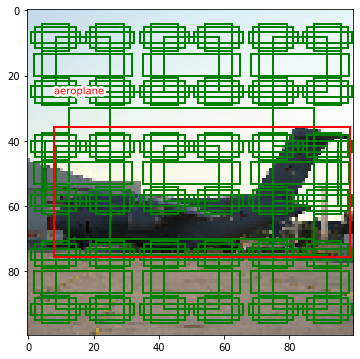

In [578]:
import albumentations as A

trans = A.Compose([
    A.Resize(100, 100)
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

labels, bbs = anns
augmented = trans(**{'image': img_np, 'bboxes': bbs, 'labels': labels})
img, bbs, labels = augmented['image'], augmented['bboxes'], augmented['labels']

plot_anchors(img, (labels, bbs), anchors)
plt.show()

In [579]:
img_tensor = torch.FloatTensor(img / 255.).permute(2,0,1).unsqueeze(0).to(device)
bb_norm = [norm(bb, img.shape[:2]) for bb in bbs]
bb_tensor = torch.FloatTensor(bb_norm).unsqueeze(0).to(device)
label_tensor = torch.tensor(labels).long().unsqueeze(0).to(device)

img_tensor.shape, bb_tensor.shape, label_tensor.shape

(torch.Size([1, 3, 100, 100]), torch.Size([1, 1, 4]), torch.Size([1, 1]))

In [580]:
model = SSD(n_classes = len(classes), k=k)
fit(model, img_tensor, (bb_tensor, label_tensor), epochs=100)

Epoch 1/100 loss 3.15287
Epoch 2/100 loss 3.14288
Epoch 3/100 loss 3.13321
Epoch 4/100 loss 3.12305
Epoch 5/100 loss 3.11200
Epoch 6/100 loss 3.09954
Epoch 7/100 loss 3.08533
Epoch 8/100 loss 3.06889
Epoch 9/100 loss 3.04957
Epoch 10/100 loss 3.02663
Epoch 11/100 loss 2.99950
Epoch 12/100 loss 2.96707
Epoch 13/100 loss 2.92832
Epoch 14/100 loss 2.88331
Epoch 15/100 loss 2.82919
Epoch 16/100 loss 2.76437
Epoch 17/100 loss 2.68728
Epoch 18/100 loss 2.59801
Epoch 19/100 loss 2.49365
Epoch 20/100 loss 2.37002
Epoch 21/100 loss 2.22362
Epoch 22/100 loss 2.05320
Epoch 23/100 loss 1.87045
Epoch 24/100 loss 1.66518
Epoch 25/100 loss 1.44438
Epoch 26/100 loss 1.22984
Epoch 27/100 loss 1.02189
Epoch 28/100 loss 0.83204
Epoch 29/100 loss 0.66695
Epoch 30/100 loss 0.52934
Epoch 31/100 loss 0.41900
Epoch 32/100 loss 0.33453
Epoch 33/100 loss 0.27127
Epoch 34/100 loss 0.22592
Epoch 35/100 loss 0.19698
Epoch 36/100 loss 0.17037
Epoch 37/100 loss 0.14681
Epoch 38/100 loss 0.13502
Epoch 39/100 loss 0.1

## Generando predicciones

Una vez tenemos nuestro modelo entrenado, podemos generar predicciones de la siguiente manera

In [581]:
def predict(model, X):
    model.eval()
    with torch.no_grad():
        X = X.to(device)
        bbs, labels = model(X)
        bbs = actn_to_bb(bbs[0].cpu(), anchors, grid_size)
    return bbs, torch.max(torch.softmax(labels.cpu(), axis=2)[0], axis=1)

In [582]:
bbs, (scores, labels) = predict(model, img_tensor)
bbs = [unnorm(bb, img.shape[:2]) for bb in bbs]

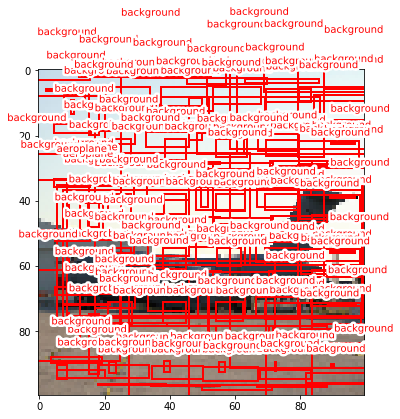

In [583]:
plot_anns(img, (labels, bbs))
plt.show()

Tenemos tantas predicciones como cajas propuestas, y la mayoría por defecto tendrán asignada la clase `background` que no nos interesa, así que descartamos todas estas cajas.

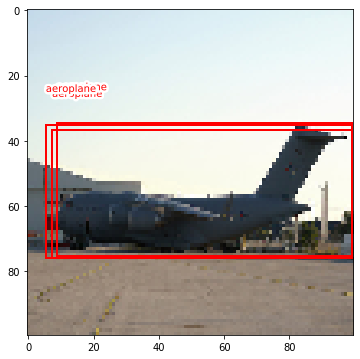

In [584]:
plot_anns(img, (labels, bbs), bg=0)
plt.show()

Aún así, es posible que tengamos varias detecciones para un mismo objeto. Para resolver este problema podemos aplicar el algoritmo `NMS`(*non maximum supression*) que calcula el `IoU` de las detecciones con la misma clase y, si este valor está por encima de un cierto *threshold*, devuelve solo la detección con mayor probabilidad.

In [585]:
bbs, (scores, labels) = predict(model, img_tensor)
# quitar bg
bbs, labels, scores = bbs[labels > 0], labels[labels > 0], scores[labels > 0]
bbs, labels, scores

(tensor([[0.0724, 0.3656, 0.9923, 0.7584],
         [0.0864, 0.3451, 0.9954, 0.7547],
         [0.0533, 0.3503, 0.9910, 0.7586]]),
 tensor([1, 1, 1]),
 tensor([0.9668, 0.9613, 0.9392]))

In [586]:
nms_ixs = torchvision.ops.nms(bbs, scores, iou_threshold=0.8)
nms_ixs

tensor([0])

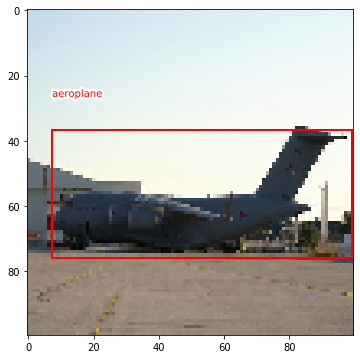

In [587]:
bbs, labels = bbs[nms_ixs], labels[nms_ixs]
bbs = [unnorm(bb, img.shape[:2]) for bb in bbs]
plot_anns(img, (labels, bbs))
plt.show()

Ahora puedes intentar entrenar este modelo para el resto de imágenes del dataset. Es posible aplicar *transfer learning*, sustituyendo nuestra `bakcbone` por una red preentrenada (por ejemplo `resenet`) y sacando las cabezas de detecciones de los diferentes mapas de características intermedios (puedes añadir capas extras para seguir reduciendo la dimensionalidad como en la implementación original).

## Resumen

En este post hemos aprendido a implementar un modelo de detección de objetos desde cero, inspirándonos en el modelo `SSD`. En primer lugar, hemos definido un conjunto de cajas que durante el entrenamiento nuestra red utilizará para detectar objetos. La salida de la red neuronal nos dará unos *offsets* sobre estas cajas a la vez que la distribución de probabilidad sobre todos los posibles objetos. Utilizamos la métric `IoU` para determinar qué cajas se parecen más a las anotaciones, y optimizar para sólo este conjunto. Por último, utilizamos el algorimto `NMS` para eliminar duplicados a la hora de generar predicciones.